# Notebook for the development of the model to power the face detection

### Imports

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import torch
from torchvision.datasets import WIDERFace
from torchvision.models.detection.faster_rcnn import fasterrcnn_mobilenet_v3_large_320_fpn, FasterRCNN_MobileNet_V3_Large_320_FPN_Weights
from collections import defaultdict
import os
import random

### Constants

In [2]:
ROOT = "/content/" # Change to your root directory

### Download Data

In [3]:
WIDERFace(root="", download=True)

Downloading...
From (original): https://drive.google.com/uc?id=15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M
From (redirected): https://drive.usercontent.google.com/download?id=15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M&confirm=t&uuid=d313549c-36bb-4358-8cfa-0fd7d9323a05
To: /content/widerface/WIDER_train.zip
100%|██████████| 1.47G/1.47G [00:25<00:00, 57.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q
From (redirected): https://drive.usercontent.google.com/download?id=1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q&confirm=t&uuid=cbfa45f2-bfdd-473d-979e-8ece2b5cdd0f
To: /content/widerface/WIDER_val.zip
100%|██████████| 363M/363M [00:09<00:00, 40.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T
From (redirected): https://drive.usercontent.google.com/download?id=1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T&confirm=t&uuid=53f82dd1-fd35-4c76-a684-3ef0202a7e84
To: /content/widerface/WIDER_test.zip
100%|██████████| 1.84G/1.84G 

100%|██████████| 3591642/3591642 [00:00<00:00, 14472206.76it/s]


Extracting widerface/wider_face_split.zip to widerface


Dataset WIDERFace
    Number of datapoints: 12880
    Root location: widerface
    Split: train

## Data Exploration

### Build dictionary with image name and folder as key and a list with the number of faces and the coordinates of the bounding boxes as value

In [5]:
# Make list from ground truth .txt file
ground_truth_file_list = []
with open(ROOT + "widerface/wider_face_split/wider_face_train_bbx_gt.txt") as file:
  for line in file:
    ground_truth_file_list.append(line.strip())

In [6]:
images_ground_truth = {}
index = 0
while index < len(ground_truth_file_list):
  if len(ground_truth_file_list[index].split(".")) == 2:
    image_name = ground_truth_file_list[index].strip()
    index += 1
    num_faces = int(ground_truth_file_list[index].strip())
    ground_truth = [num_faces]
    for _ in range(num_faces):
      index += 1
      ground_truth.append(list(map(lambda x: int(x), ground_truth_file_list[index].split(" ")))[:4]) # only num_faces / x, y, width, height
    images_ground_truth[image_name] = ground_truth
  index += 1

### Visualize 4 random example images with bounding boxes

In [7]:
def plot_image(axs, x, y, image):
  ground_truth = images_ground_truth[image]
  axs[x, y].imshow(mpimg.imread(ROOT + "widerface/WIDER_train/images/" + image))
  for rect in ground_truth[1:]:
    rect_x, rect_y, width, height = rect
    rect_obj = patches.Rectangle((rect_x, rect_y), width, height, linewidth=2, edgecolor='r', facecolor='none')
    axs[x, y].add_patch(rect_obj)
  image_name = image.split("/")[1].split(".")[0]
  axs[x, y].set_title(image_name)

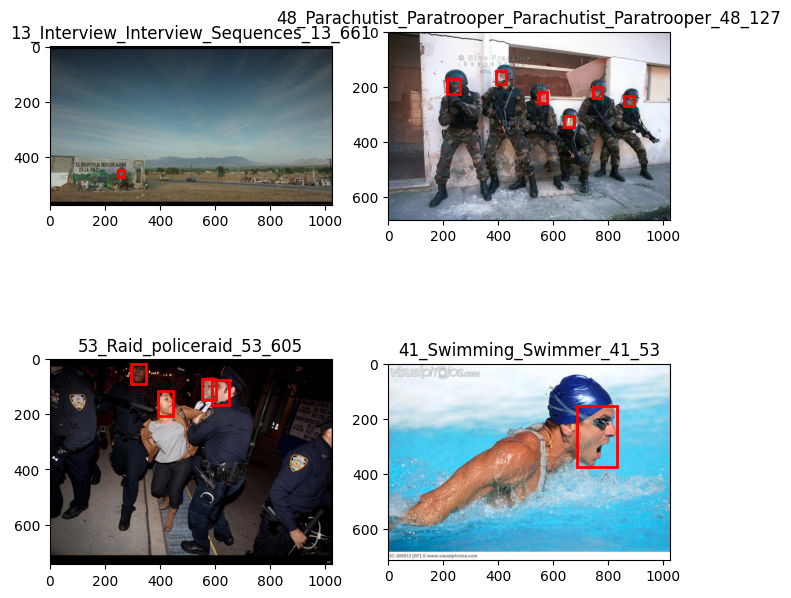

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

images = random.sample(list(images_ground_truth.keys()), 4)
# Plot first image
plot_image(axs, 0, 0, images[0])
# Plot second image
plot_image(axs, 0, 1, images[1])
# Plot third image
plot_image(axs, 1, 0, images[2])
# Plot fourth image
plot_image(axs, 1, 1, images[3])

### Explore Distribution over number of faces
-> Use log scale to better visualize extreme values

In [9]:
dist_num_faces = defaultdict(int)
with open(ROOT + "widerface/wider_face_split/wider_face_train_bbx_gt.txt") as file:
  for line in file:
    if len(line.split(" ")) == 1 and len(line.split(".")) == 1:
      dist_num_faces[int(line)] += 1
print(f"There are {dist_num_faces[0]} images with zero faces.")

There are 4 images with zero faces.


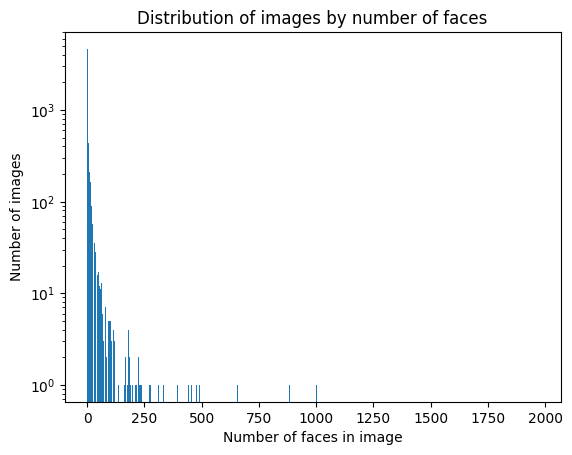

In [10]:
num_faces = list(dist_num_faces.keys())
frequency = list(dist_num_faces.values())

plt.bar(num_faces, frequency, log=True)
plt.xlabel('Number of faces in image')
plt.ylabel('Number of images')
plt.title('Distribution of images by number of faces')

plt.show()

## Build Data Loaders

In [16]:
# auto transformation
weights = FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT
transforms = weights.transforms()

Build DataSet

In [26]:
base_path = ROOT + "widerface/WIDER_train/images/"
image_paths = [base_path + image_name for image_name in images_ground_truth]
annotations = []
for image_name in images_ground_truth:
  annotation = {"boxes": [], "labels": []}
  for box in images_ground_truth[image_name][1:]:
    annotation["boxes"].append(box)
    annotation["labels"].append(1)
  annotations.append(annotation)